In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

# Using Machine Learning to predict Sea Surface Temperature

For this second part, we will now focus on the bottle and cast data. The bottle data contains oceangraphic data and cast data this describes the dates and latitude and longitude. This data was retrived from the California Cooperative Oceanic Fisheries Investigations (CalCOFI). This data comprises of 60 years of oceanographic data. Let now start exploring our data, we will start with some Exploratory Data Analysis (EDA). 
- For EDA this article was relatively followed

https://towardsdatascience.com/tackling-climate-crisis-with-machine-learning-d9426fe1f5a9

### Data Exploration & Data Cleaning 

In [2]:
bottle_df = pd.read_csv('/Users/elenaeguiarte/Documents/Data Science/Capstone/CalCOFI_Database_194903-202001_csv_22Sep2021/194903-202001_Bottle.csv', encoding="ISO-8859-1", dtype={"47": str, "61": float}, low_memory=False)

In [3]:
print(f'Our Dataframe has {bottle_df.shape[0]} rows and {bottle_df.shape[1]} columns.')

Our Dataframe has 889500 rows and 62 columns.


In [4]:
bottle_df.head()

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_DYNHT,R_Nuts,R_Oxy_µmol/Kg,DIC1,DIC2,TA1,TA2,pH1,pH2,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889500 entries, 0 to 889499
Data columns (total 62 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Cst_Cnt              889500 non-null  int64  
 1   Btl_Cnt              889500 non-null  int64  
 2   Sta_ID               889500 non-null  object 
 3   Depth_ID             889500 non-null  object 
 4   Depthm               889500 non-null  int64  
 5   T_degC               878535 non-null  float64
 6   Salnty               842145 non-null  float64
 7   O2ml_L               719993 non-null  float64
 8   STheta               836808 non-null  float64
 9   O2Sat                685072 non-null  float64
 10  Oxy_µmol/Kg          685061 non-null  float64
 11  BtlNum               135538 non-null  float64
 12  RecInd               889500 non-null  int64  
 13  T_prec               878537 non-null  float64
 14  T_qual               23129 non-null   float64
 15  S_prec           

For the purposes of this project we will only be focusing in some features since some columns have replicated columns.  

In [6]:
# Let's slice our dataframe
calcofi_columns = bottle_df.loc[:, 'Depthm':'O2Satq']

# And drop T_degC since this is our targer variable 
calcofi_columns = calcofi_columns.drop('T_degC', axis=1)

# Run Correlation Matrix 
corr_matrix = calcofi_columns.corr()

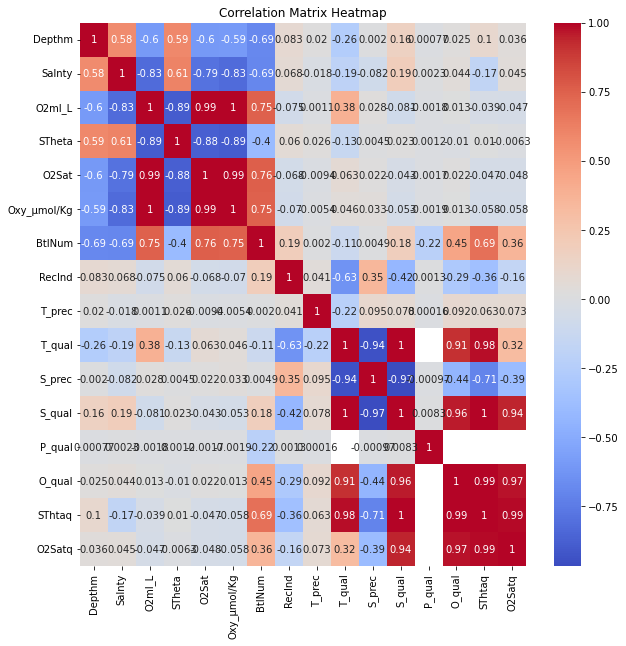

In [7]:
plt.figure(figsize=(10, 10)) 
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

In this case heat map will not be used to visualize the correlation between all features since the heat map will look a little busy. Instead, let's plot the correlation of all our features using a bar graph

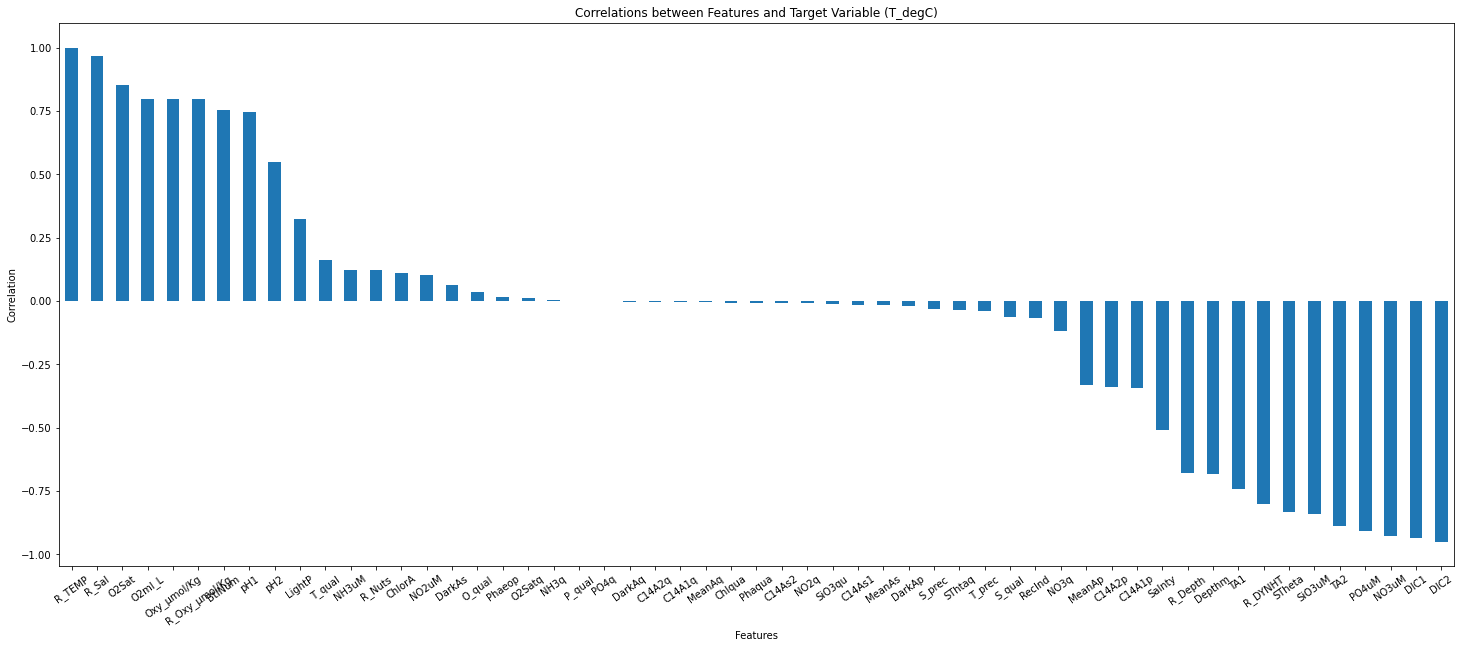

In [8]:
# Let's plot a bar graph 

# Let's calculate the correlations one more time and add all features
calcofi_corr = bottle_df.loc[:, 'Depthm':'pH2'].corr()

# Drop T_degC
correlations = calcofi_corr['T_degC'].drop('T_degC').sort_values(ascending=False)

# Plot
plt.figure(figsize=(25, 10))  
correlations.plot(kind='bar')
plt.title('Correlations between Features and Target Variable (T_degC)')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=35)
plt.show()

We can now better understand our features that show a strong correlation, where some variables show a strong positve correlation whereas other show a strong negative correlation. Let's select the features that we will be keeping:

Kept: `O2Sat`, `O2ml_L`, `Oxy_µmol/Kg` , `R_Sal`, `Depthm`, `STheta`, `PO4um`,  `NO3uM`, `SiO3uM`, `pH1`, `DIC1`

Removed: `T_qual`, `Recind`, `ChlorA`, `O_qual`,`Phaeop`, `O2Satq`, `P_qual`, `PO4q`, `Chlqua`, `Phaqua`, `S_prec`, `SThtaq`, `T_prec`, `S_qual`, `BtlNum` that is the features that show no correlation which are located in the middle will not be included in the models.

**RecInd** and **BtlNum** are features that show a high and low correlation but these features are just indicators and IDs from the bottle sampling, (BtlNum is the bottle number and the RecInd is the Record Indicator). Other features were not kept because of the following reasons:
- **ph2**: Is the degree of acidity/alkalinity of a solution on a replicate sample. That is it is the same measurement for pH but was replicated. 
- **R_Oxy_µmol/Kg**: Is the same as `Oxy_µmol/Kg` but it is the reported result. 
- **DIC2**: Is the Dissolved Inorganic Carbon micromoles per kilogram solution (on a replicate sample) but is the same as `DIC1` but has different units (Dissolved Inorganic Carbon micromoles per kilogram solution)
- **R_Depth**: Is the Reported Depth in Meters this is the same as `Depthm`
- **C14A2q**: This is a quality code not necessary 
- **C14A1p**: This is a replict from 14C 

To learn more about the Field Discriptions (Key) of the Bottle Table please visit the following link:

https://calcofi.org/data/oceanographic-data/bottle-database/

Let's now move on by creating a new dataframe with our filtered features and target variables:

In [9]:
# Which features have replicated columns? 
calcofifeature2 = bottle_df.loc[:, ('R_Sal','Salnty','R_TEMP','T_degC', 'R_Oxy_µmol/Kg','Oxy_µmol/Kg','Depthm','R_Depth')]
calcofifeature2

,R_Sal,Salnty,R_TEMP,T_degC,R_Oxy_µmol/Kg,Oxy_µmol/Kg,Depthm,R_Depth
0,233.0,33.4400,10.50,10.500,NaN,NaN,0,0.0
1,232.5,33.4400,10.46,10.460,NaN,NaN,8,8.0
2,232.8,33.4370,10.46,10.460,NaN,NaN,10,10.0
3,234.1,33.4200,10.45,10.450,NaN,NaN,19,19.0
4,234.0,33.4210,10.45,10.450,NaN,NaN,20,20.0
...,...,...,...,...,...,...,...,...
889495,326.0,33.4849,15.60,15.599,256.51,256.51,5,5.0
889496,325.5,33.4857,15.57,15.570,254.87,254.87,10,10.0
889497,323.0,33.4824,15.43,15.434,253.00,253.00,16,16.0
889498,322.0,33.4725,15.34,15.347,247.42,247.42,20,20.0


In [10]:
calcofifeature2.describe()

,R_Sal,Salnty,R_TEMP,T_degC,R_Oxy_µmol/Kg,Oxy_µmol/Kg,Depthm,R_Depth
count,836719.000000,842145.000000,843450.000000,878535.000000,685061.000000,685061.000000,889500.000000,889499.000000
mean,221.322961,33.837428,10.856391,10.814859,149.089192,149.088396,224.851225,226.406083
std,93.290779,0.459275,4.223074,4.230723,90.100650,90.100223,312.888116,316.252681
min,0.400000,28.365200,0.000000,1.440000,-0.434900,-0.434900,0.000000,0.000000
25%,144.100000,33.487000,7.750000,7.700000,61.760590,61.760000,45.000000,45.000000
50%,203.800000,33.860000,10.110000,10.070000,151.493000,151.493900,125.000000,126.000000
75%,300.200000,34.191000,13.940000,13.900000,240.558500,240.558500,300.000000,302.000000
max,683.400000,37.034000,31.140000,31.140000,485.701800,485.701800,5351.000000,5458.000000


Here, we can observe the features that have replicate columns. This why some columns that have high correlation were not included.

In [11]:
# Select the calcofi features that will be kept
calcofi_features = ['O2Sat', 'O2ml_L', 'Oxy_µmol/Kg', 'R_Sal', 'Depthm', 'STheta', 'PO4uM', 'NO3uM', 'SiO3uM','pH1', 'DIC1']

# Append the features witht the target variable 
calcofi_features.extend(['T_degC', 'Cst_Cnt'])

# Create a new data dataframe
filtered_df = bottle_df[calcofi_features]
filtered_df

,O2Sat,O2ml_L,Oxy_µmol/Kg,R_Sal,Depthm,STheta,PO4uM,NO3uM,SiO3uM,pH1,DIC1,T_degC,Cst_Cnt
0,NaN,NaN,NaN,233.0,0,25.64900,NaN,NaN,NaN,NaN,NaN,10.500,1
1,NaN,NaN,NaN,232.5,8,25.65600,NaN,NaN,NaN,NaN,NaN,10.460,1
2,NaN,NaN,NaN,232.8,10,25.65400,NaN,NaN,NaN,NaN,NaN,10.460,1
3,NaN,NaN,NaN,234.1,19,25.64300,NaN,NaN,NaN,NaN,NaN,10.450,1
4,NaN,NaN,NaN,234.0,20,25.64300,NaN,NaN,NaN,NaN,NaN,10.450,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
889495,103.60,5.877,256.51,326.0,5,24.67354,0.21,0.0,2.06,NaN,NaN,15.599,35376
889496,102.87,5.839,254.87,325.5,10,24.68095,0.21,0.0,2.02,NaN,NaN,15.570,35376
889497,101.83,5.796,253.00,323.0,16,24.70894,0.22,0.0,2.04,NaN,NaN,15.434,35376
889498,99.56,5.677,247.42,322.0,20,24.72076,0.28,0.0,2.21,NaN,NaN,15.347,35376


Additional notes:
- Remember that `append` function is used for to add a single element to the list. For multiple items `extend` is used.

In [12]:
print(f'Our Dataframe has {filtered_df.shape[0]} rows and {filtered_df.shape[1]} columns.')

Our Dataframe has 889500 rows and 13 columns.


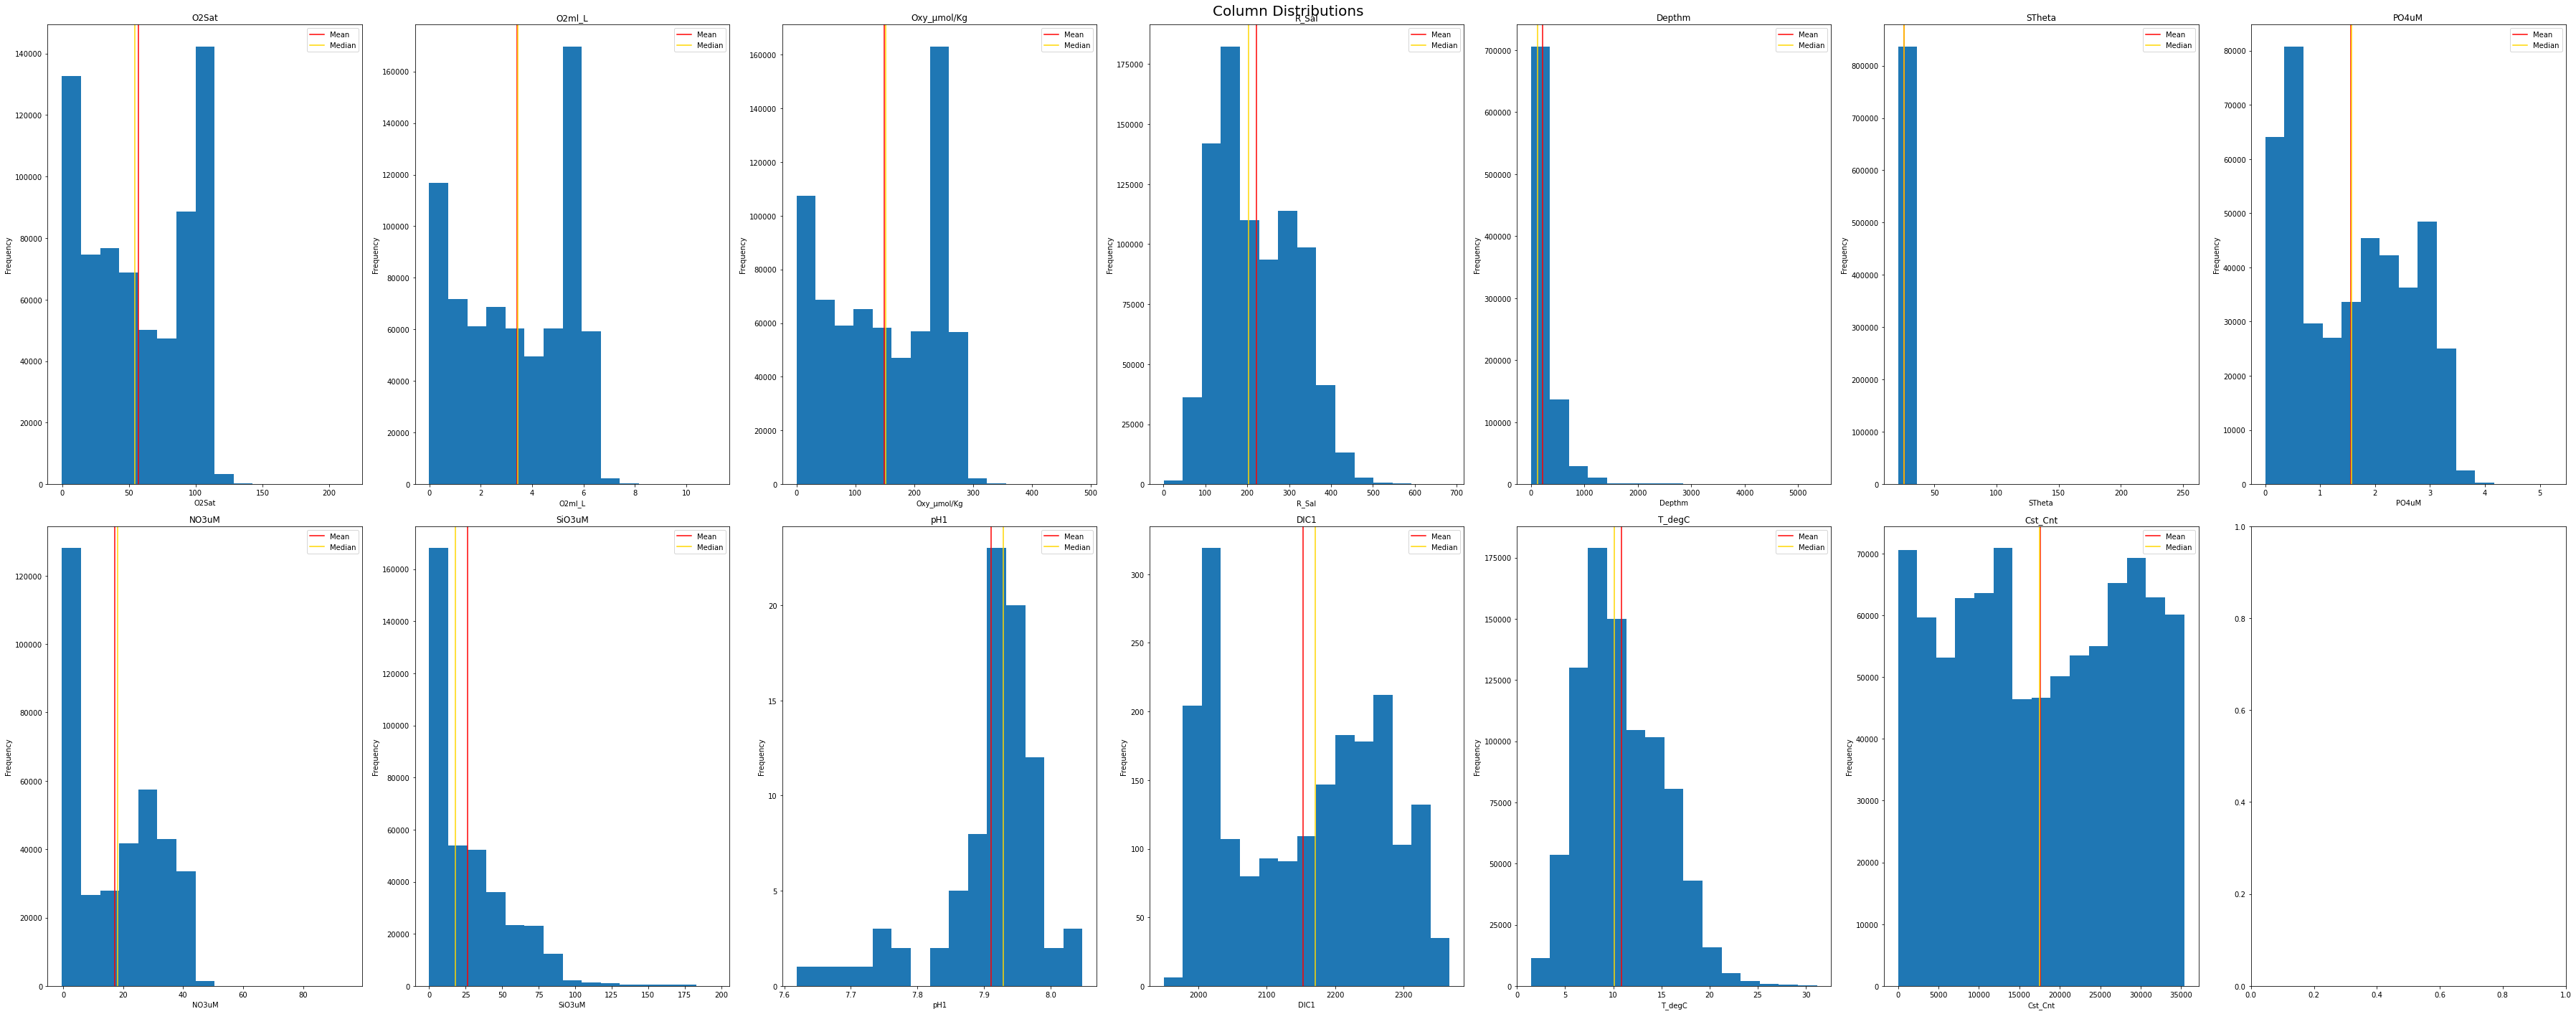

In [13]:
# First, let's take a look at the distribution of our data
plt.subplots(2, 7, figsize=(50, 20))
plt.suptitle('Column Distributions', size=20)

# Creating the for loop
for slot_num, each_column in enumerate(filtered_df.columns, start=1):

    # Creating a hist for every iteration
    plt.subplot(2, 7, slot_num)
    plt.hist(filtered_df[each_column], bins=15)

    # Adding labels to the plots  
    plt.title(each_column)
    plt.xlabel(each_column)
    plt.ylabel('Frequency')

    # Adding median and mean lines
    plt.axvline(filtered_df[each_column].mean(), c='red', label='Mean')
    plt.axvline(filtered_df[each_column].median(), c='gold', label='Median')
    plt.legend()

plt.tight_layout()

plt.show()

From the plots shown above, there are some normal distributions. However, for `Depthm` there is righ-skewed the same applies to `SiO3uM`. Whereas `pH1` is skewed to the left.

Mean or mode?

Look at the row that has missing values and find similarity to other rows and have it filled in
Sample with distribution 

Randomly pick values from this

In [14]:
# Missing values
filtered_df.isnull().sum()

O2Sat          204428
O2ml_L         169507
Oxy_µmol/Kg    204439
R_Sal           52781
Depthm              0
STheta          52692
PO4uM          454050
NO3uM          529961
SiO3uM         513274
pH1            889416
DIC1           887501
T_degC          10965
Cst_Cnt             0
dtype: int64

In [15]:
# Let's take a look at our missing values
null_values = filtered_df.isnull().sum() / len(filtered_df)  * 100
null_values

# Shared loss?

O2Sat          22.982350
O2ml_L         19.056436
Oxy_µmol/Kg    22.983586
R_Sal           5.933783
Depthm          0.000000
STheta          5.923777
PO4uM          51.045531
NO3uM          59.579651
SiO3uM         57.703654
pH1            99.990556
DIC1           99.775267
T_degC          1.232715
Cst_Cnt         0.000000
dtype: float64

In [16]:
# We will drop two additional columns (DIC1 and pH1) this is bacause 99% of these values are missing
filtered_df.drop(['pH1', 'DIC1'] ,axis=1)

,O2Sat,O2ml_L,Oxy_µmol/Kg,R_Sal,Depthm,STheta,PO4uM,NO3uM,SiO3uM,T_degC,Cst_Cnt
0,NaN,NaN,NaN,233.0,0,25.64900,NaN,NaN,NaN,10.500,1
1,NaN,NaN,NaN,232.5,8,25.65600,NaN,NaN,NaN,10.460,1
2,NaN,NaN,NaN,232.8,10,25.65400,NaN,NaN,NaN,10.460,1
3,NaN,NaN,NaN,234.1,19,25.64300,NaN,NaN,NaN,10.450,1
4,NaN,NaN,NaN,234.0,20,25.64300,NaN,NaN,NaN,10.450,1
...,...,...,...,...,...,...,...,...,...,...,...
889495,103.60,5.877,256.51,326.0,5,24.67354,0.21,0.0,2.06,15.599,35376
889496,102.87,5.839,254.87,325.5,10,24.68095,0.21,0.0,2.02,15.570,35376
889497,101.83,5.796,253.00,323.0,16,24.70894,0.22,0.0,2.04,15.434,35376
889498,99.56,5.677,247.42,322.0,20,24.72076,0.28,0.0,2.21,15.347,35376


In [17]:
# What about the shared loss of these columns let's check it out

# Let's take a look at the null values
nulls_occur_together = filtered_df['O2Sat'].isnull() & filtered_df['Oxy_µmol/Kg'].isnull().sum()

# Now we will calculate where both O2Sat and Oxy_µmol/Kg have null values
num_nulls_together = nulls_occur_together.sum()

# Print the result
print("Number of rows where null values in O2Sat and Oxy_µmol/Kg occur together:", num_nulls_together)

Number of rows where null values in O2Sat and Oxy_µmol/Kg occur together: 204428


In [18]:
# Let's now drop the null values that occur together
clean_df = filtered_df[~nulls_occur_together]

In [19]:
#we will drop two additional columns (DIC1 and pH1) this is bacause 99% of these values are missing

clean_df = filtered_df.drop(['pH1', 'DIC1'] ,axis=1)

Let's now decide how to fill in the values, by using the mean of the values or by dropping the values:

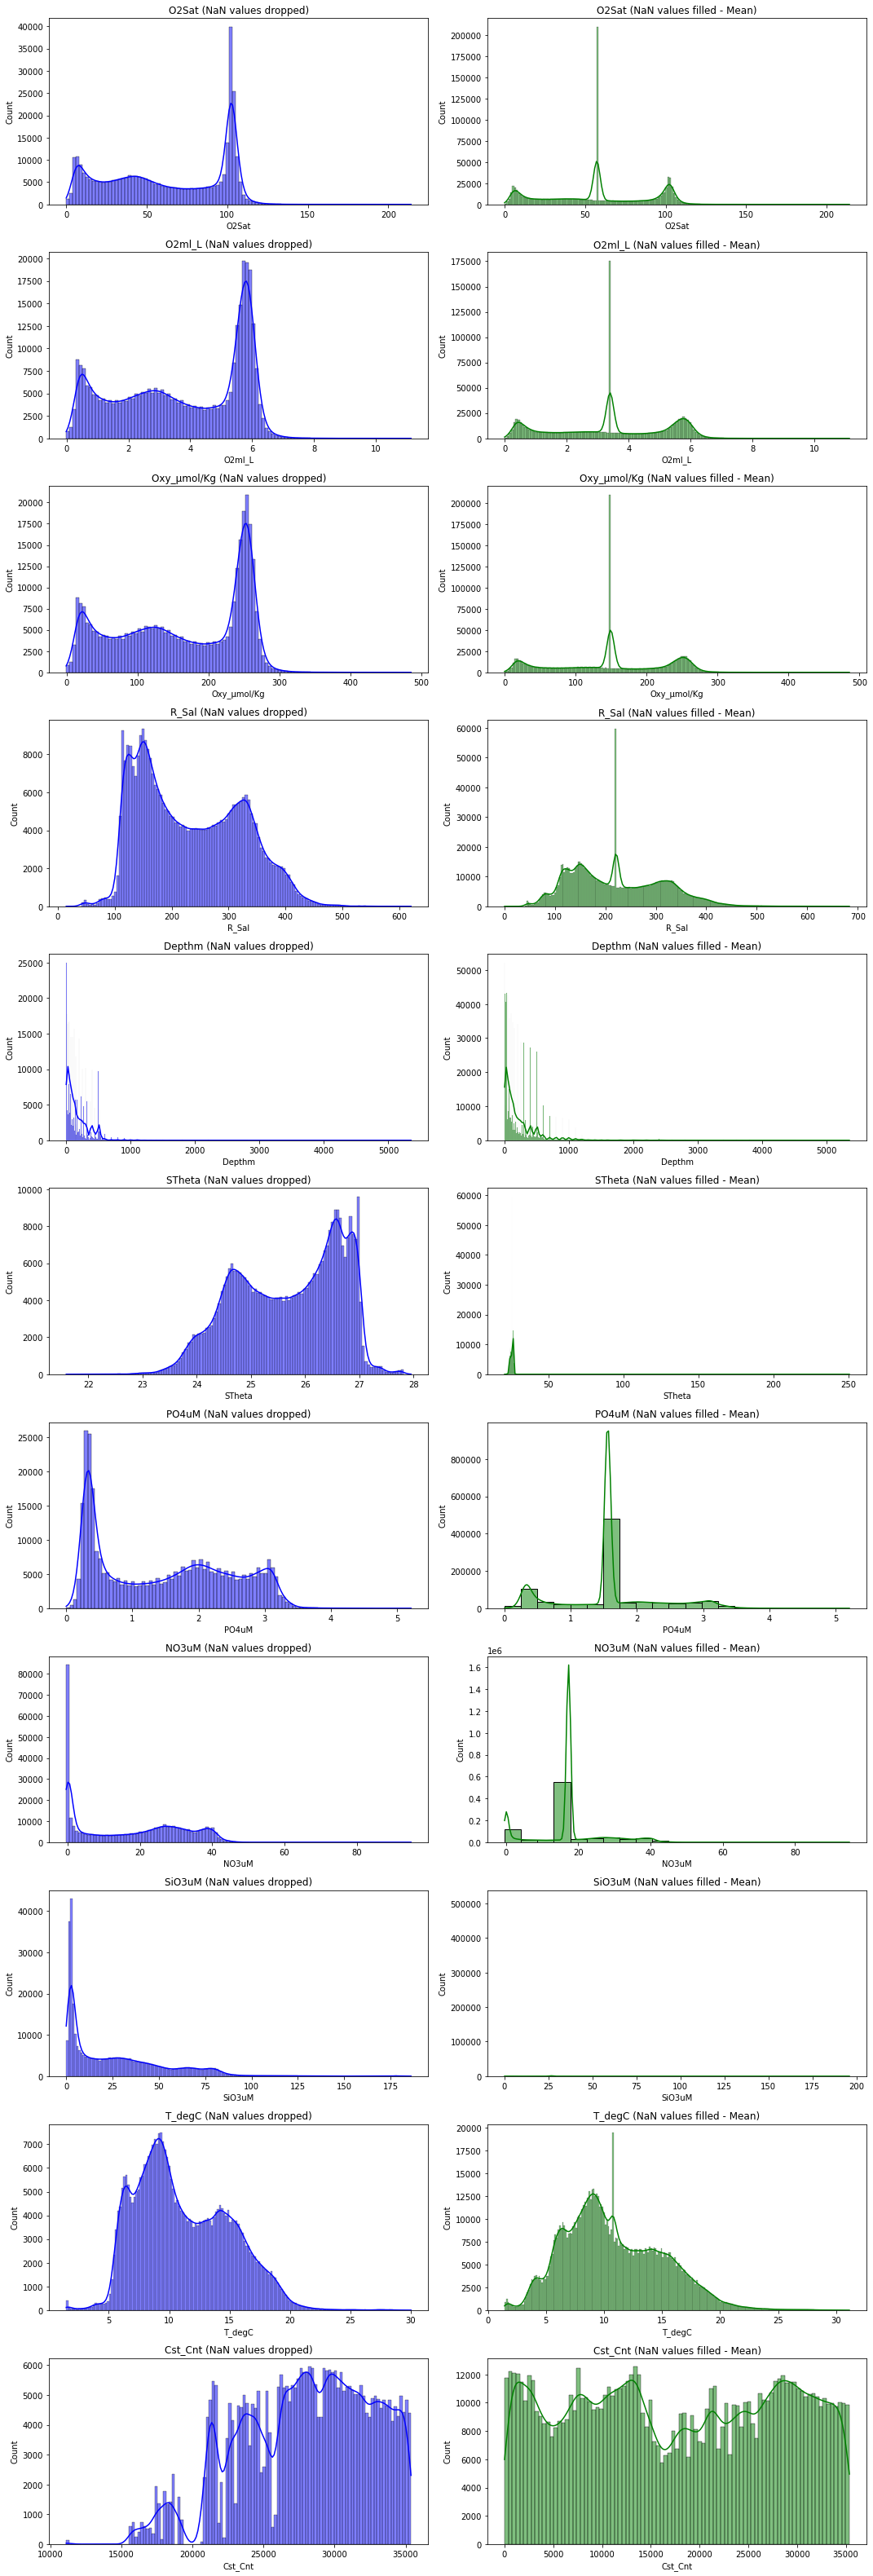

In [20]:
# Let's compare the two dataframes: one with NaN values dropped and with fillna with mean
df_dropped = clean_df.dropna()
df_filled = clean_df.fillna(filtered_df.mean())

# Let's set up the plot layout
n_features = len(clean_df.columns)
n_cols = 2
n_rows = n_features
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 4))

# Plot the distributions for the DataFrame with NaN values dropped
for i, column in enumerate(df_dropped.columns):
    sns.histplot(data=df_dropped, x=column, kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'{column} (NaN values dropped)')

# Plot the distributions for the DataFrame with NaN values filled with mean
for i, column in enumerate(df_filled.columns):
    sns.histplot(data=df_filled, x=column, kde=True, ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'{column} (NaN values filled - Mean)')

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

In this case we cannot see much change in the distrubition of data, however since more than half of our data is missing will go ahead fill in the values using the mean.

In [21]:
clean_df2 = clean_df.fillna(clean_df.mean())
clean_df2

,O2Sat,O2ml_L,Oxy_µmol/Kg,R_Sal,Depthm,STheta,PO4uM,NO3uM,SiO3uM,T_degC,Cst_Cnt
0,57.212537,3.399236,149.088396,233.0,0,25.64900,1.558441,17.295643,26.496258,10.500,1
1,57.212537,3.399236,149.088396,232.5,8,25.65600,1.558441,17.295643,26.496258,10.460,1
2,57.212537,3.399236,149.088396,232.8,10,25.65400,1.558441,17.295643,26.496258,10.460,1
3,57.212537,3.399236,149.088396,234.1,19,25.64300,1.558441,17.295643,26.496258,10.450,1
4,57.212537,3.399236,149.088396,234.0,20,25.64300,1.558441,17.295643,26.496258,10.450,1
...,...,...,...,...,...,...,...,...,...,...,...
889495,103.600000,5.877000,256.510000,326.0,5,24.67354,0.210000,0.000000,2.060000,15.599,35376
889496,102.870000,5.839000,254.870000,325.5,10,24.68095,0.210000,0.000000,2.020000,15.570,35376
889497,101.830000,5.796000,253.000000,323.0,16,24.70894,0.220000,0.000000,2.040000,15.434,35376
889498,99.560000,5.677000,247.420000,322.0,20,24.72076,0.280000,0.000000,2.210000,15.347,35376


In [22]:
# Sanity Check
clean_df2.isnull().sum()

O2Sat          0
O2ml_L         0
Oxy_µmol/Kg    0
R_Sal          0
Depthm         0
STheta         0
PO4uM          0
NO3uM          0
SiO3uM         0
T_degC         0
Cst_Cnt        0
dtype: int64

In [23]:
# How about duplicates
clean_df2.duplicated().sum()

68

In [24]:
clean_df2.duplicated().sum()/clean_df2.shape[0]*100.0

0.0076447442383361435

It appears that approximately 0.003% of the dataset is duplicated on the row-level. Let's investigate this.

In [25]:
clean_df2[clean_df2.duplicated(keep=False)].head(100)

,O2Sat,O2ml_L,Oxy_µmol/Kg,R_Sal,Depthm,STheta,PO4uM,NO3uM,SiO3uM,T_degC,Cst_Cnt
690269,105.200000,5.590000,243.827500,402.5,20,23.877000,0.210000,0.000000,2.500000,18.990,28066
690273,105.200000,5.590000,243.827500,402.5,20,23.877000,0.210000,0.000000,2.500000,18.990,28066
690304,57.212537,3.399236,149.088396,415.7,10,25.815065,1.558441,17.295643,26.496258,19.590,28067
690307,57.212537,3.399236,149.088396,415.7,10,25.815065,1.558441,17.295643,26.496258,19.590,28067
690308,57.212537,3.399236,149.088396,415.3,10,25.815065,1.558441,17.295643,26.496258,19.570,28067
...,...,...,...,...,...,...,...,...,...,...,...
858743,85.620000,5.228000,227.760000,284.9,102,25.132600,1.558441,17.295643,26.496258,12.136,34170
858745,102.860000,5.811000,253.390000,371.9,2,24.190600,1.558441,17.295643,26.496258,15.965,34170
858746,102.240000,5.803000,253.030000,367.2,10,24.243240,1.558441,17.295643,26.496258,15.730,34170
858747,102.250000,5.875000,256.130000,353.1,25,24.396010,1.558441,17.295643,26.496258,15.117,34170


All samples are unique when `Blt_Cnt` (Bottle Count - All CalCOFI bottles ever sampled, consecutively numbered)  is included in the table (this was tested by adding the the `Blt_Cnt` in the calcofi_features input but was removed since it has a high correlation with sea surface temperature and it is not a feature that actually influences change in the sea surface temperature. However, once removed there are a total of 21 duplicates (0.006%) in this case some of these samples where in the same cast (in the same cruise) but had their own unique bottle that is why some duplicates are observed with the `Cst_Cnt` (Cast Count - All CalCOFI casts ever conducted, consecutively numbered) and without the `Btl_Cnt` in this case these duplicates will be removed since duplicates show a very low percentage.
- The reason why we are keeping `Cst_Cnt` is because the Cast Dataframe and the Bottle Dataframe have this feature this important since we would like to merge these dataframes and will be matched according to their `Cst_Cnt`.

In [26]:
# Let's now drop our duplicates
clean_df3 = clean_df2.drop_duplicates()
clean_df3

,O2Sat,O2ml_L,Oxy_µmol/Kg,R_Sal,Depthm,STheta,PO4uM,NO3uM,SiO3uM,T_degC,Cst_Cnt
0,57.212537,3.399236,149.088396,233.0,0,25.64900,1.558441,17.295643,26.496258,10.500,1
1,57.212537,3.399236,149.088396,232.5,8,25.65600,1.558441,17.295643,26.496258,10.460,1
2,57.212537,3.399236,149.088396,232.8,10,25.65400,1.558441,17.295643,26.496258,10.460,1
3,57.212537,3.399236,149.088396,234.1,19,25.64300,1.558441,17.295643,26.496258,10.450,1
4,57.212537,3.399236,149.088396,234.0,20,25.64300,1.558441,17.295643,26.496258,10.450,1
...,...,...,...,...,...,...,...,...,...,...,...
889495,103.600000,5.877000,256.510000,326.0,5,24.67354,0.210000,0.000000,2.060000,15.599,35376
889496,102.870000,5.839000,254.870000,325.5,10,24.68095,0.210000,0.000000,2.020000,15.570,35376
889497,101.830000,5.796000,253.000000,323.0,16,24.70894,0.220000,0.000000,2.040000,15.434,35376
889498,99.560000,5.677000,247.420000,322.0,20,24.72076,0.280000,0.000000,2.210000,15.347,35376


In [27]:
# Sanity check
clean_df3.duplicated().sum()

0

### Cast Data

Let's now take a look at our cast data, this data set will be used to merge the`Date`, `Lon_Deg` and the `Lat_Deg` to our clean_df2. The `Cst_Cnt` will be used to match the dataframe from the `clean_df2`.

In [28]:
cast_df = pd.read_csv("/Users/elenaeguiarte/Documents/Data Science/Capstone/CalCOFI_Database_194903-202001_csv_22Sep2021/194903-202001_Cast.csv", low_memory=False)

In [29]:
cast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35376 entries, 0 to 35375
Data columns (total 61 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cst_Cnt      35376 non-null  int64  
 1   Cruise_ID    35376 non-null  object 
 2   Cruise       35376 non-null  int64  
 3   Cruz_Sta     35376 non-null  int64  
 4   DbSta_ID     35376 non-null  int64  
 5   Cast_ID      35376 non-null  object 
 6   Sta_ID       35376 non-null  object 
 7   Quarter      35376 non-null  int64  
 8   Sta_Code     35376 non-null  object 
 9   Distance     20686 non-null  float64
 10  Date         35376 non-null  object 
 11  Year         35376 non-null  int64  
 12  Month        35376 non-null  int64  
 13  Julian_Date  35376 non-null  int64  
 14  Julian_Day   35376 non-null  int64  
 15  Time         35052 non-null  object 
 16  Lat_Dec      35376 non-null  float64
 17  Lat_Deg      35376 non-null  int64  
 18  Lat_Min      35376 non-null  float64
 19  Lat_

In [30]:
# Null Values?
cast_df[['Lat_Deg', 'Lon_Deg', 'Cst_Cnt', 'Date']].isnull().sum()

Lat_Deg    0
Lon_Deg    0
Cst_Cnt    0
Date       0
dtype: int64

It is important to remember that the `cast_df` is only metadata, but what we want to extract from here are the features shown above. These features will be used for our models and that way we can learn more about the locations  where we  see the most sea temperature change.

In [31]:
# How about duplicates
cast_df.duplicated().sum()

0

In [32]:
cast_df2 = cast_df.loc[:, ['Date','Cst_Cnt', 'Lat_Deg', 'Lon_Deg']]
cast_df2

,Date,Cst_Cnt,Lat_Deg,Lon_Deg
0,3/1/1949,1,38,-124
1,3/1/1949,2,38,-125
2,3/2/1949,3,38,-126
3,3/2/1949,4,38,-127
4,3/2/1949,5,38,-128
...,...,...,...,...
35371,1/7/2020,35372,30,-121
35372,1/7/2020,35373,30,-122
35373,1/7/2020,35374,30,-122
35374,1/8/2020,35375,29,-123


There are no missing values and no duplicates for the `cast_df`dataframe. We will now merge the data from our `clean_df2` and the `cast_df2`, the rows will be matchaed according to their `Cst_Cnt` that is the cast count which are all the CalCOFI casts ever conducted.
The `merge()` function will be used by performing a left join (`how=left`). This will keep all rows from `clean_df2` and adds the columns from the `cast_df2` where the `Cst_Cnt` values match. 

In [34]:
merged_df = pd.merge(clean_df3, cast_df2, on='Cst_Cnt', how='left')
merged_df

,O2Sat,O2ml_L,Oxy_µmol/Kg,R_Sal,Depthm,STheta,PO4uM,NO3uM,SiO3uM,T_degC,Cst_Cnt,Date,Lat_Deg,Lon_Deg
0,57.212537,3.399236,149.088396,233.0,0,25.64900,1.558441,17.295643,26.496258,10.500,1,3/1/1949,38,-124
1,57.212537,3.399236,149.088396,232.5,8,25.65600,1.558441,17.295643,26.496258,10.460,1,3/1/1949,38,-124
2,57.212537,3.399236,149.088396,232.8,10,25.65400,1.558441,17.295643,26.496258,10.460,1,3/1/1949,38,-124
3,57.212537,3.399236,149.088396,234.1,19,25.64300,1.558441,17.295643,26.496258,10.450,1,3/1/1949,38,-124
4,57.212537,3.399236,149.088396,234.0,20,25.64300,1.558441,17.295643,26.496258,10.450,1,3/1/1949,38,-124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889427,103.600000,5.877000,256.510000,326.0,5,24.67354,0.210000,0.000000,2.060000,15.599,35376,1/5/2020,32,-117
889428,102.870000,5.839000,254.870000,325.5,10,24.68095,0.210000,0.000000,2.020000,15.570,35376,1/5/2020,32,-117
889429,101.830000,5.796000,253.000000,323.0,16,24.70894,0.220000,0.000000,2.040000,15.434,35376,1/5/2020,32,-117
889430,99.560000,5.677000,247.420000,322.0,20,24.72076,0.280000,0.000000,2.210000,15.347,35376,1/5/2020,32,-117


In [139]:
merged_df.to_csv('merged_data.csv', index=False)

In [35]:
# Sanity Check
merged_df.duplicated().sum()

0

In [36]:
# Sanity Check
merged_df.isna().sum()

O2Sat          0
O2ml_L         0
Oxy_µmol/Kg    0
R_Sal          0
Depthm         0
STheta         0
PO4uM          0
NO3uM          0
SiO3uM         0
T_degC         0
Cst_Cnt        0
Date           0
Lat_Deg        0
Lon_Deg        0
dtype: int64

In [37]:
print(f'Our merged Dataframe has {merged_df.shape[0]} rows and {merged_df.shape[1]} columns.')

Our merged Dataframe has 889432 rows and 14 columns.


Great! Our data has now been successfully merged and there are no null values and duplicates. This will be the new merged dataframe that will be used for our models.

### Linear Regression Model

Since all of the data is continous we will proceed to work on a linear regression model. Regression analysis is used to model the relationship between a single **dependent variable Y (target variable in this case it is `T_degC`)** and one or more **independent variables X** (the predictor features that have been already selected while EDA was performed).

- For this model this article was followed closely:

https://medium.com/towards-data-science/linear-regression-model-with-python-481c89f0f05b

In [106]:
# Let's define the independent variables X (aka predictors or features)
X = merged_df.iloc[:,1:9]
X

,O2ml_L,Oxy_µmol/Kg,R_Sal,Depthm,STheta,PO4uM,NO3uM,SiO3uM
0,3.399236,149.088396,233.0,0,25.64900,1.558441,17.295643,26.496258
1,3.399236,149.088396,232.5,8,25.65600,1.558441,17.295643,26.496258
2,3.399236,149.088396,232.8,10,25.65400,1.558441,17.295643,26.496258
3,3.399236,149.088396,234.1,19,25.64300,1.558441,17.295643,26.496258
4,3.399236,149.088396,234.0,20,25.64300,1.558441,17.295643,26.496258
...,...,...,...,...,...,...,...,...
889427,5.877000,256.510000,326.0,5,24.67354,0.210000,0.000000,2.060000
889428,5.839000,254.870000,325.5,10,24.68095,0.210000,0.000000,2.020000
889429,5.796000,253.000000,323.0,16,24.70894,0.220000,0.000000,2.040000
889430,5.677000,247.420000,322.0,20,24.72076,0.280000,0.000000,2.210000


In [107]:
# Let's now define the dependent variable y (target)
y = merged_df.iloc[:,9:10]
y

,T_degC
0,10.500
1,10.460
2,10.460
3,10.450
4,10.450
...,...
889427,15.599
889428,15.570
889429,15.434
889430,15.347


In [108]:
# Remember when using scikit-learn the X dimension needs to be 2D and y must be 1D
X.shape

(889432, 8)

In [109]:
# Sanity Check
y.shape

(889432, 1)

In [110]:
# Using squeeze function will be able to make it one 1D 
y = np.squeeze(y)

In [111]:
# Sanity Check
y.shape

(889432,)

Let's run some **model diagnostics** first:

**Before running the model** we will start with the following diagnostics:

1. Linearity: Relationship between X and the mean of Y is linear. (Scatter Plot independent vs dependent)
2. No multicollinearity: There is no high correlation between predictor variables.  (Heat map)

#### Linearity

Let's take a look at Linearity for our linear regression model. We first assume that that there is a linear relationship between the parametes of independent variables (features) and the dependent variable (target variable). 

https://towardsdatascience.com/linear-regression-assumptions-why-is-it-important-af28438a44a1

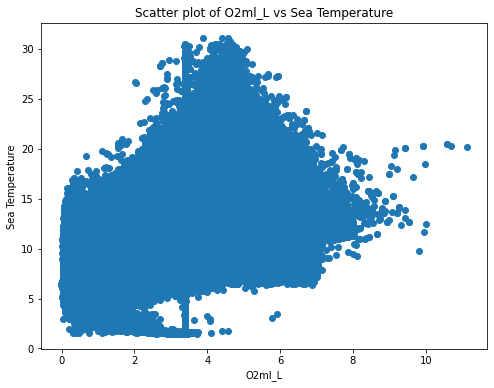

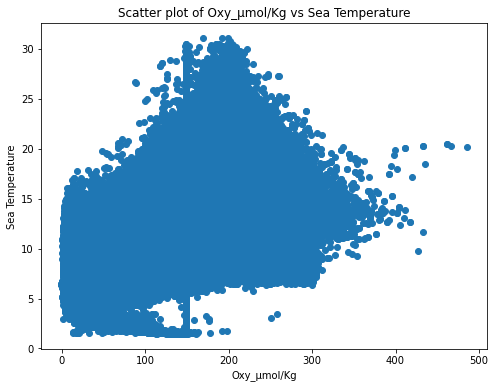

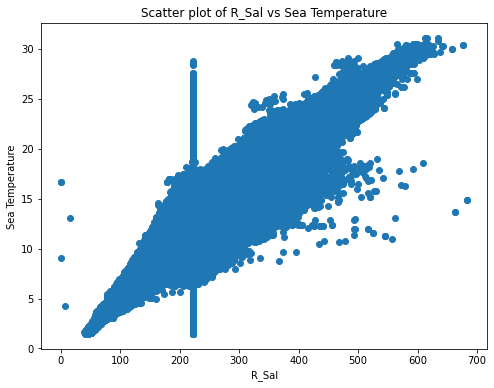

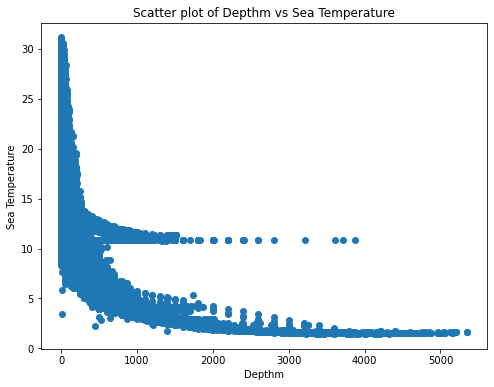

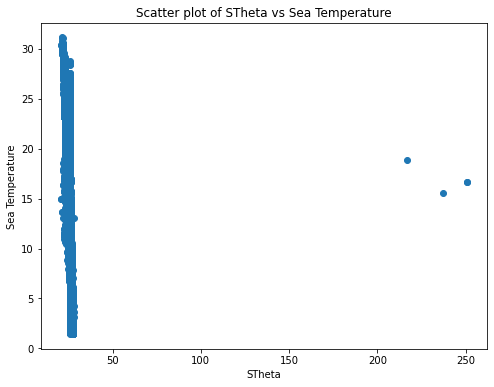

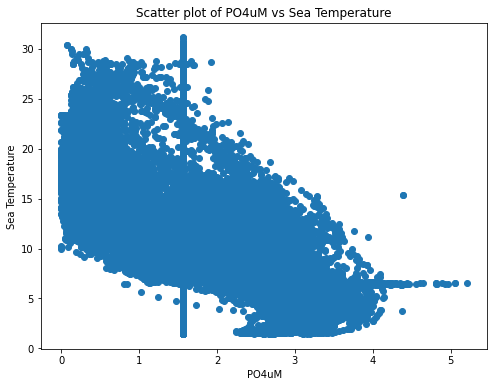

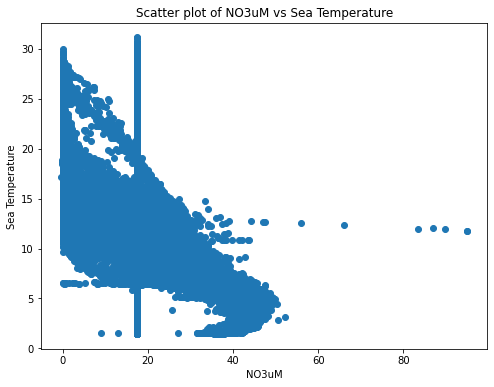

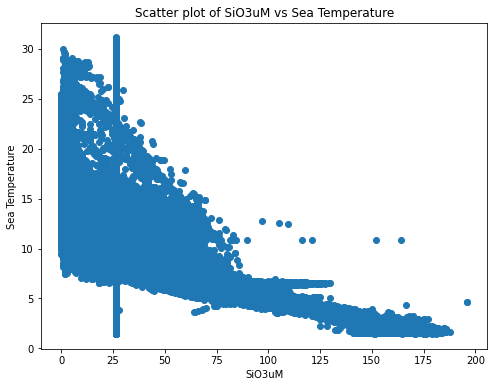

In [112]:
for column in X.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(X[column], y)
    plt.xlabel(column)
    plt.ylabel('Sea Temperature')
    plt.title(f'Scatter plot of {column} vs Sea Temperature')
    plt.show()

From the graphs shown above we can see that there is linearity between `T_degC` and `R_Sal` however, there is not much linearity between the other features. Since there is no relationship between these features this will affect the linear regression model, but for now let's move on to Multicollinearity.

#### Multicollinearity

Let's check for multicollinearity by using a correlation matrix. A correlation matrix provides a measure of the linear relationships between pairs of variables. High correlation coefficients (close to 1 or -1) between independent variables indicate multicollinearity. We will also perform Variance Inflation Factor (VIF) which is a measure of multicullinearity among the independent variables. Multicollinearity is the statistical concept where several independent variables in a model are correlated making it difficult to determine the individual effect of each variable on the dependent variable.

VIF is interpreted the following way:
- VIF = 1
- 1 < VIF < 5: Moderate multicollinearity. 
- VIF >= 5 or VIF >=10: High multicollinearity.

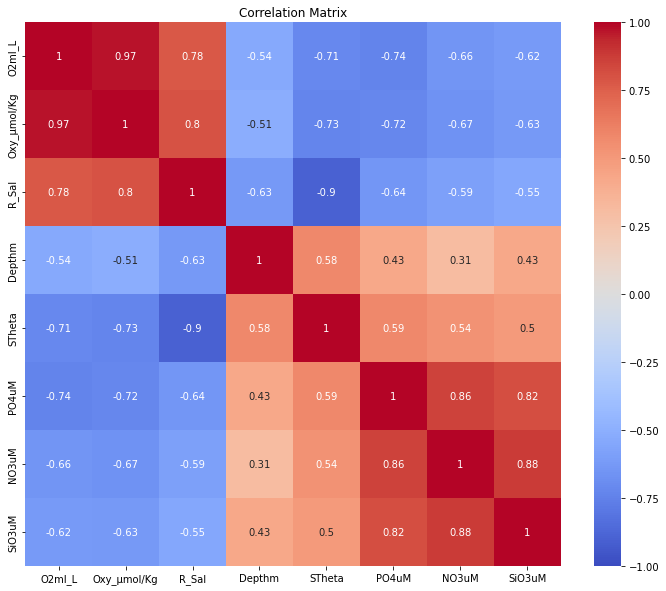

In [113]:
corr_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [114]:
# Creates a range object that represent a sequence of integers from 0 (inclusive) to number of columns in the X dataframe (exclusive)
range(X.shape[1])

range(0, 8)

In [115]:
# There a total of 8 columns
X.shape[1]

8

In [116]:
# VIF test 

# Created an empty dataframe
vif = pd.DataFrame()

# Then added a column known as features
vif["Features"] = X.columns

# Then created a for loop that iterates over the range of the number of columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Features,VIF
0,O2ml_L,94.761081
1,Oxy_µmol/Kg,103.603126
2,R_Sal,22.981722
3,Depthm,3.115456
4,STheta,43.268403
5,PO4uM,29.507843
6,NO3uM,30.220142
7,SiO3uM,16.929340


In [117]:
# Let's redefine our X 
X = X.drop(['Oxy_µmol/Kg', 'STheta'], axis=1)
X

,O2ml_L,R_Sal,Depthm,PO4uM,NO3uM,SiO3uM
0,3.399236,233.0,0,1.558441,17.295643,26.496258
1,3.399236,232.5,8,1.558441,17.295643,26.496258
2,3.399236,232.8,10,1.558441,17.295643,26.496258
3,3.399236,234.1,19,1.558441,17.295643,26.496258
4,3.399236,234.0,20,1.558441,17.295643,26.496258
...,...,...,...,...,...,...
889427,5.877000,326.0,5,0.210000,0.000000,2.060000
889428,5.839000,325.5,10,0.210000,0.000000,2.020000
889429,5.796000,323.0,16,0.220000,0.000000,2.040000
889430,5.677000,322.0,20,0.280000,0.000000,2.210000


In this case we dropped `Oxy_µmol/Kg` and `STheta`. The reason being is because  `R_Sal` and `Stheta` have a high correlation `Stheta` is the potential density of seawater and salinity describes how much salt is present in seawater. The more salt there is the greater the salinity; when comparing two samples of water of the same volume, the water sample with higher salinity will have a greater mass therefore will be more dense that is why there is a high correlation between these two.  Whereas the `O2ml_L` vs `Oxy_µmol/Kg` is the measurement of oxygen in seawater the only difference between these two features are their units (milliliters oxygen per liter of seawater and oxygen micromoles per kilogram seawater). 

Resource:

- https://manoa.hawaii.edu/exploringourfluidearth/physical/density-effects/density-temperature-and-salinity

Why is multicollinearity important?

When to features are very closely related to each other it can make it difficult to understand which variable is actually affects the target (dependent variable) because these variables are mixed up. In this case we can see that `O2ml_L`,`Oxy_µmol/Kg` and `Stheta`, `R_Sal` show a high multicollinearity. In order to make the linear regression model more reliable we will need to remove one or more of the variables that are closely related.

In [118]:
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Features,VIF
0,O2ml_L,12.396608
1,R_Sal,16.372194
2,Depthm,2.236276
3,PO4uM,22.832565
4,NO3uM,27.684654
5,SiO3uM,15.538782


From the features that were dropped, there is still high multicollinearity between some features. Let's take a look at the `PO4uM` and `NO3uM` (Micromoles Phosphate per liter of seawater andMicromoles Nitrate per liter of seawater). Nitrate (NO3-) and phospahte (PO4 3-) are primarily related related through their roles as essential nutrients for plant and algae growth, their sources, and their impacts on water quality. The main relationship between these two features is that they are both a food source for algae. 

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgrc.20249

Let's go ahead drop on of these two features.

In [119]:
# Let's redefine our X 
X = X.drop(['NO3uM'], axis=1)
X

,O2ml_L,R_Sal,Depthm,PO4uM,SiO3uM
0,3.399236,233.0,0,1.558441,26.496258
1,3.399236,232.5,8,1.558441,26.496258
2,3.399236,232.8,10,1.558441,26.496258
3,3.399236,234.1,19,1.558441,26.496258
4,3.399236,234.0,20,1.558441,26.496258
...,...,...,...,...,...
889427,5.877000,326.0,5,0.210000,2.060000
889428,5.839000,325.5,10,0.210000,2.020000
889429,5.796000,323.0,16,0.220000,2.040000
889430,5.677000,322.0,20,0.280000,2.210000


In [120]:
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Features,VIF
0,O2ml_L,12.242088
1,R_Sal,16.242238
2,Depthm,2.084401
3,PO4uM,13.210301
4,SiO3uM,9.722669


We can still observe high multicullinearity between these features. Specially in `Salnty` and `PO4uM`. Salinity and Phosphate sorption has been found to increase temperature and decrease salinity. These two features are also correlated.

https://pubmed.ncbi.nlm.nih.gov/21707091/

In [121]:
# Let's redefine our X 
X = X.drop(['PO4uM'], axis=1)
X

,O2ml_L,R_Sal,Depthm,SiO3uM
0,3.399236,233.0,0,26.496258
1,3.399236,232.5,8,26.496258
2,3.399236,232.8,10,26.496258
3,3.399236,234.1,19,26.496258
4,3.399236,234.0,20,26.496258
...,...,...,...,...
889427,5.877000,326.0,5,2.060000
889428,5.839000,325.5,10,2.020000
889429,5.796000,323.0,16,2.040000
889430,5.677000,322.0,20,2.210000


In [122]:
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Features,VIF
0,O2ml_L,12.021740
1,R_Sal,14.519074
2,Depthm,1.922162
3,SiO3uM,3.134953


In [123]:
# Let's redefine our X 
X = X.drop(['SiO3uM'], axis=1)
X

,O2ml_L,R_Sal,Depthm
0,3.399236,233.0,0
1,3.399236,232.5,8
2,3.399236,232.8,10
3,3.399236,234.1,19
4,3.399236,234.0,20
...,...,...,...
889427,5.877000,326.0,5
889428,5.839000,325.5,10
889429,5.796000,323.0,16
889430,5.677000,322.0,20


In [124]:
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Features,VIF
0,O2ml_L,11.168289
1,R_Sal,11.526390
2,Depthm,1.147029


These are the final theree features that will be used to run the linear regression model. Despite not having an VIF socores less than five we will proceed with the linear regression model since there are only three features left.

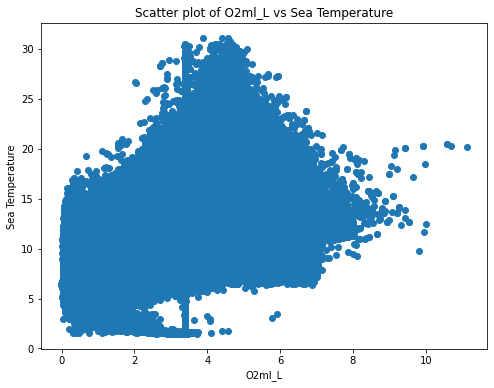

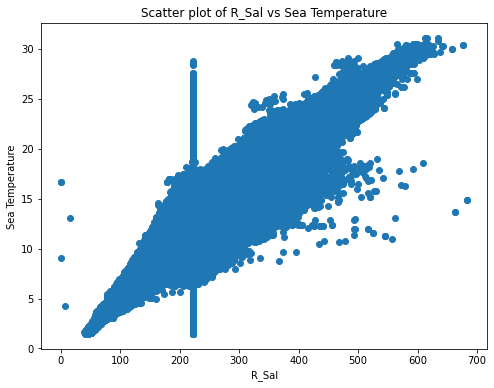

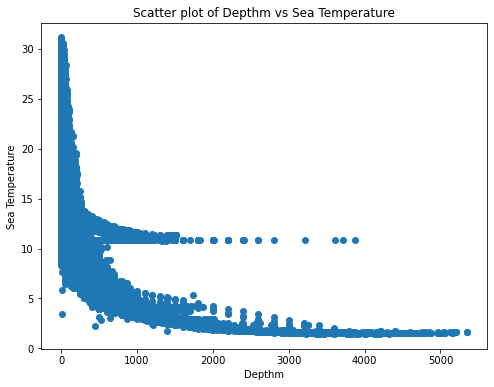

In [125]:
# Let's check for linearity one more time 

for column in X.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(X[column], y)
    plt.xlabel(column)
    plt.ylabel('Sea Temperature')
    plt.title(f'Scatter plot of {column} vs Sea Temperature')
    plt.show()

In this case we can observe that there is not strong correlation or relationship between `Depthm` and `O2ml_L` after dropping multiple columns but there `R_Sal` still demonstrates a strong relationship.

#### Linear Regression Model

In [126]:
# Step 1 Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
# Step 2 Design Pipeline

estimators = [
    ('scaler', StandardScaler()),  
    ('model', LinearRegression())
]

my_pipe = Pipeline(estimators)

In [128]:
# Step 3 Fit the pipeline to the training data
my_pipe.fit(X_train, y_train)
print(f'R²: {my_pipe.score(X_test, y_test)}')

R²: 0.8900938209720138


In [129]:
# Step 4 Predict using the variable in the test set

y_pred = my_pipe.predict(X_test)

In [130]:
# Step 4 Evaluate

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1.9367113972621173
R-squared: 0.8900938209720138


#### Model Diagnostics

**After running Linear Regression Model**

1. Normality: Residuals follow a normal distribution and the expected mean of the residuals is zero. 
2. Homoscedasticity (Stats Model): Variance of residuals is constant for all values of X. y vs y_predict

#### Normality 

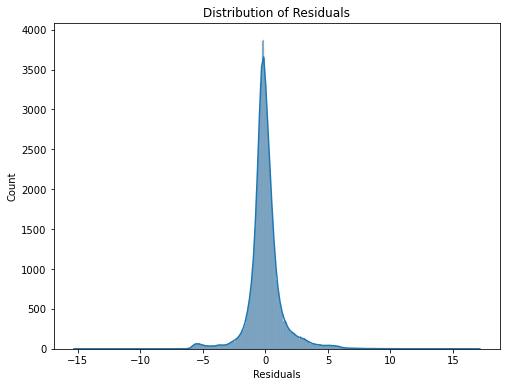

In [131]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

**Residuals**: 

Residuals in Linear Regression is difference between the actual value and the predicted value. 
One important assumption in Linear Regression model is that the residuals are normally distributed. In this case we can oberseve that are residuals are normally distributed. 

In this case the average cross-validation socore is 91.3%. This means that the on average, the machine learning pipeline is able to correctly predict the outcome for 91.3% of the data accross the five different validation sets, created during the cross-validation process. 


https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda

In [90]:
# Cross Validation 

avg_val_score = np.mean(cross_val_score(my_pipe, X_train, y_train, cv=5))
print(f"Average cross-validation score: {avg_val_score*100:0.1f}%'")

Average cross-validation score: 91.3%'


####  Homoscedasticity

Homoscedasticity is when the residuals have an equal variance for every values of the fitted and values and of the predictors. It essentially means the 'same variance'. In this case it can observed from the plot shown below that  we do not shown an equal variance between the residuals and predicted values. However eventually the plot shows homoscedasticity. That is tells us that the spread of data or error is the same across differente levels. 


https://sscc.wisc.edu/sscc/pubs/RegDiag-R/homoscedasticity.html

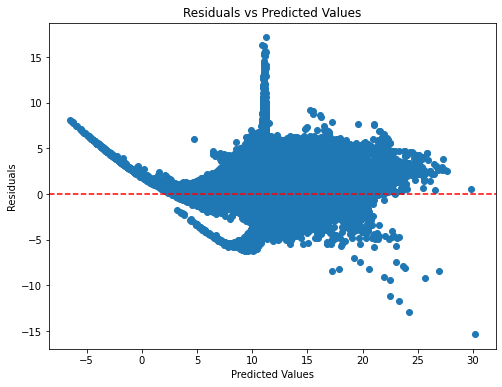

In [132]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

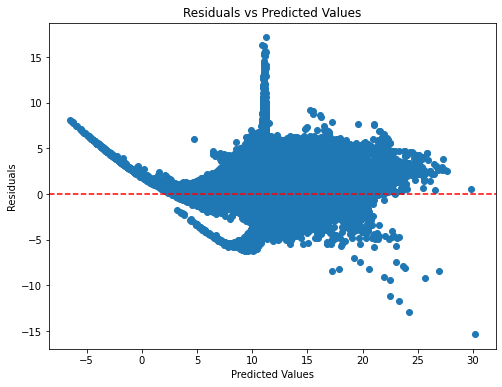

In [133]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

output_file = 'Residuals.png'  # Specify the output file name
dpi_value = 300  
plt.savefig(output_file, dpi=dpi_value, bbox_inches='tight', format='png')

In [138]:
 my_pipe.named_steps['model'].intercept_

10.812698922643506

In [135]:
# Take a look at the coefficients
coefficients_df = pd.DataFrame(my_pipe.named_steps['model'].coef_, index=X_train.columns, columns=['Coefficient'])
coefficients_df

,Coefficient
O2ml_L,-0.221961
R_Sal,3.711430
Depthm,-0.633463


In this case, the coefficients that were obtained represent the contribution of each feature to the prediction of the target variable. The equation can be written as:

$$ Temperature = 10.81 - 0.221O2ml_L - 0.633Depthm + 3.711RSal $$


Assuming that all variables remain constant, for each unit in oxygen concentration (O2ml_L) the water temperature is expected to decrease by approximately 0.221 degrees Celsius, similarly for each unit in salinity (R_Sal) the water tempeature is expected to increase by around 3.711 degrees. Lastly, for each unit increase in depth (Depthm), the temperature is expected to decrease by approximately 0.633 degress.

This all based under the assumptions that there is a linear relationship between each feature and the target variable, which in this case there was only a linear relationship in R_Sal but not depth and oxygen concentration.

The shown plot above appears demonstrate some heteroscedasticity this means that the spread or variability of data points is not the same meaning the data point are spread out everywhere. However, we then can oberserve that the model shows homoscedasticity that is the plot shows  constant variance. 

Why is homoscedasticity important? 

Homoscedasticity is an important assumption because it ensures that the model's estimates are accurate, unbiased, and efficient. Homoscedasticity is where the variance of the error terms (i.e. residuals) are constant across all levels of the independent variables.

https://towardsdatascience.com/linear-regression-with-ols-heteroskedasticity-and-autocorrelation-c12f1f65c13

Additional Notes:

1. Mean Squared Error (MSE): Measures how close a regression line is to a set of a data point. 

#### Decision Tree Regression Model

decision tree regression model, plot fitted data 

In [74]:
# Let's define the independent variables X (aka predictor or feature)
X = merged_df.iloc[:,1:9]
X

,O2ml_L,Oxy_µmol/Kg,R_Sal,Depthm,STheta,PO4uM,NO3uM,SiO3uM
0,3.399236,149.088396,233.0,0,25.64900,1.558441,17.295643,26.496258
1,3.399236,149.088396,232.5,8,25.65600,1.558441,17.295643,26.496258
2,3.399236,149.088396,232.8,10,25.65400,1.558441,17.295643,26.496258
3,3.399236,149.088396,234.1,19,25.64300,1.558441,17.295643,26.496258
4,3.399236,149.088396,234.0,20,25.64300,1.558441,17.295643,26.496258
...,...,...,...,...,...,...,...,...
889427,5.877000,256.510000,326.0,5,24.67354,0.210000,0.000000,2.060000
889428,5.839000,254.870000,325.5,10,24.68095,0.210000,0.000000,2.020000
889429,5.796000,253.000000,323.0,16,24.70894,0.220000,0.000000,2.040000
889430,5.677000,247.420000,322.0,20,24.72076,0.280000,0.000000,2.210000


In [75]:
# Target Variable
y = merged_df.iloc[:,9:10]
y

,T_degC
0,10.500
1,10.460
2,10.460
3,10.450
4,10.450
...,...
889427,15.599
889428,15.570
889429,15.434
889430,15.347


In [76]:
y = np.squeeze(y)

In [77]:
# Sanity Check
X.shape

(889432, 8)

In [78]:
# Sanity Check 
y.shape

(889432,)

In [79]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Fit Decison Tree 
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [81]:
# Define Hyperparameters for Decision Tree 
parameters = {'max_depth': [5, 10, 15, 20],
             'min_samples_split': [50, 100, 150, 200],
             'min_samples_leaf': [50, 100, 150, 200],
             'max_features': ['auto', 'sqrt', 'log2']} 

Why are is Random Search being used instead of Grid Search? 

- Grid Search: Involves a set of values for each hyperparameter that you want to tune. The method then evaluate the model using every possible combination of hyperparameters within the specified ranges creating a grid of all possible combinations. Grid Search is exhaustive (it will try all combinations of hyperparameters which can be computationally expensive and time consuming) specially when dealing with a large number of hyperparameters. It may not always find optimal combinations if the search space is too large. 

- Random Search: Is the process of randomly sampling hyperparameters from  a defined search space. The main difference is that Random search only selects a random subset of hyperparameter values whereas Grid Search goes through every single combination.

Given that there are 889,443 rows in our dataset random search is generally a better choice. Random search was choosen because it is a more efficient since Random search can explore the hyperparameter space more efficiently. 

- Resource:

https://medium.com/towards-data-science/hyperparameter-optimization-intro-and-implementation-of-grid-search-random-search-and-bayesian-b2f16c00578a

In [82]:
# Instantiate Randomized Search
rand_search = RandomizedSearchCV(
    tree,
    param_distributions=parameters,
    n_iter=100,  # number of iterations
    cv=5,  # number of cross-validation folds
    random_state=42
)

In [83]:
# Fit Rnadom Search
rand_search.fit(X_train, y_train)

# Obtain best hyperparameteres
best_params = rand_search.best_params_
print(f"Best hyperparameters: {best_params}")


# Lower depth and lower min_sample_df

Best hyperparameters: {'min_samples_split': 100, 'min_samples_leaf': 50, 'max_features': 'auto', 'max_depth': 20}


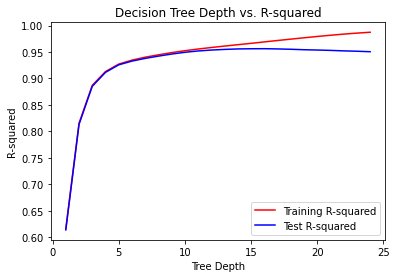

In [100]:
# Is the model overfitting? 

# Let's define a renge of depths by creating a list of depth values
max_depth_range = list(range(1, 25)) 

# Created empty lists of the scores
train_scores = []
test_scores = []

# Did a for loop this will loop through through every max_depth_range through the train set
for depth in max_depth_range:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    # Predict
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    
    # Obtain R-squared values 
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))

# Finally plot
plt.figure()
plt.plot(max_depth_range, train_scores, color='red', label='Training R-squared')
plt.plot(max_depth_range, test_scores,  color='blue', label='Test R-squared')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.title('Decision Tree Depth vs. R-squared')
plt.legend()
plt.show()

In [98]:
# Let's now train the decision tree model with the best hyperparameters

best_tree = DecisionTreeRegressor(
    min_samples_split=100,
    min_samples_leaf=50,
    max_features='auto',
    max_depth=8,
    random_state=42
)

best_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, max_features='auto', min_samples_leaf=50,
                      min_samples_split=100, random_state=42)

In [99]:
# Predict

y_pred = best_tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

R-squared: 0.9420211594611649


 In this case we can that both the training and tests are overlapping but after a tree depth at around 10 the training set starts overfitting.

In [88]:
residuals = y_test - y_pred

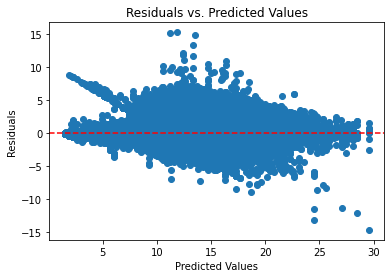

In [89]:
# Plot Residuals 

residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

### Conclusion 

In this case, it be concluded that a linear regression is more reliable than the decesion tree regression model. This because decision trees are prone to overfitting, since our score values are high and the plot where we are overfitting both training and testing data overlap each other. As for the regression model we can conclude that Salinity is the main feature that affect sea surface temperature since they have postive correlation, as for the other features there is not major impact since the other features did not show linearity. Both models have been accomplished but would like to explore alternative models such as Random Forest Regression, K-Nearest Neighbors Regression, and Neural Networks.